In [64]:
nltk.download() #nltk.download()#this will open the nltk download manager

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [23]:
import nltk
#need natin ito para mag work ang nltk. bale ang nltk ang mag support sa data preparation
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from spellchecker import SpellChecker
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import sparse
import re
import csv 

In [24]:
#pip install pyspellchecker
#pip install spellchecker
#description of the data in the Dataframe
dataframe = pd.read_csv('essay_set_descriptions.csv',encoding = 'latin-1')

dataframe.describe()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score
count,12978.000000,12978.000000,12977.000000,12977.000000,12977.000000
mean,10295.432809,4.179458,4.126840,4.137089,6.799723
std,6308.588616,2.136749,4.212537,4.264320,8.970558
min,1.000000,1.000000,0.000000,0.000000,0.000000
25%,4439.250000,2.000000,2.000000,2.000000,2.000000
50%,10045.500000,4.000000,3.000000,3.000000,3.000000
75%,15680.750000,6.000000,4.000000,4.000000,8.000000
max,21633.000000,8.000000,30.000000,30.000000,60.000000


In [25]:
dataframe.head() #gives the first five data from the dataset

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,8.0
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,9.0
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,7.0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,10.0
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,8.0


In [26]:
#checking the dataframe columns
dataframe.columns 

Index(['essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',
       'domain1_score'],
      dtype='object')

In [27]:
#checking the data on first column
dataframe.essay_id


0            1
1            2
2            3
3            4
4            5
         ...  
12973    21626
12974    21628
12975    21629
12976    21630
12977    21633
Name: essay_id, Length: 12978, dtype: int64

In [28]:
data = dataframe[['essay_set','essay','domain1_score']].copy()

print(data)

       essay_set                                              essay  \
0              1  Dear local newspaper, I think effects computer...   
1              1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2              1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3              1  Dear Local Newspaper, @CAPS1 I have found that...   
4              1  Dear @LOCATION1, I know having computers has a...   
...          ...                                                ...   
12973          8   In most stories mothers and daughters are eit...   
12974          8   I never understood the meaning laughter is th...   
12975          8  When you laugh, is @CAPS5 out of habit, or is ...   
12976          8                                 Trippin' on fen...   
12977          8   Many people believe that laughter can improve...   

       domain1_score  
0                8.0  
1                9.0  
2                7.0  
3               10.0  
4                8.0  
...      

<AxesSubplot:title={'center':'domain1_score'}, xlabel='essay_set'>

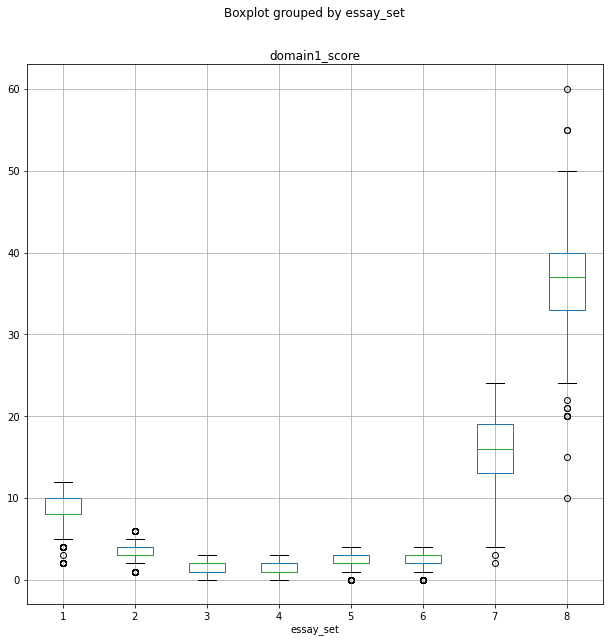

In [29]:
#plotting
# Essay sets 1-6 has a short box plot meaning that the domain1_score has a high level of agreement with the essay set. While set 7 has a difference between these two groups. 
# Lastly, the boxplot for essay_set 8 has a higher plot compared to the domain1_score
%matplotlib inline
dataframe.boxplot(column = 'domain1_score', by = 'essay_set', figsize = (10, 10))

In [30]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set(dataframe,setNumber):
    if setNumber == 1783:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        for i in range(1,1783):
            dataframe2 = dataframe[dataframe.values == 1]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
    return texts, scores


In [31]:
# get histogram plot of scores and average score
def get_hist_avg(scores,bin_count):
    print(sum(scores)/len(scores))
    scores.hist(bins=bin_count)

In [32]:
#average word length for a text
def avg_word_len(text):
    clean_essay = re.sub(r'\W', ' ', text)
    words = nltk.word_tokenize(clean_essay)
    total = 0
    for word in words:
        total = total + len(word)
    average = total / len(words)
    
    return average

# word count in a given text
def word_count(text):
    clean_essay = re.sub(r'\W', ' ', text)
    return len(nltk.word_tokenize(clean_essay))

# char count in a given text
def char_count(text):
    return len(re.sub(r'\s', '', str(text).lower()))

# sentence count in a given text
def sent_count(text):
    return len(nltk.sent_tokenize(text))

#tokenization of texts to sentences
def sent_tokenize(text):
    stripped_essay = text.strip()
    
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    raw_sentences = tokenizer.tokenize(stripped_essay)
    
    tokenized_sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            clean_sentence = re.sub("[^a-zA-Z0-9]"," ", raw_sentence)
            tokens = nltk.word_tokenize(clean_sentence)
            tokenized_sentences.append(tokens)
    return tokenized_sentences


# lemma, noun, adjective, verb, adverb count for a given text

def count_lemmas(text):
    
    noun_count = 0
    adj_count = 0
    verb_count = 0
    adv_count = 0   
    lemmas = []
    lemmatizer = WordNetLemmatizer()
    tokenized_sentences = sent_tokenize(text)
    
    for sentence in tokenized_sentences:
        tagged_tokens = nltk.pos_tag(sentence) 
        
        for token_tuple in tagged_tokens:
            pos_tag = token_tuple[1]
            
            if pos_tag.startswith('N'): 
                noun_count += 1
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('J'):
                adj_count += 1
                pos = wordnet.ADJ
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('V'):
                verb_count += 1
                pos = wordnet.VERB
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            elif pos_tag.startswith('R'):
                adv_count += 1
                pos = wordnet.ADV
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
            else:
                pos = wordnet.NOUN
                lemmas.append(lemmatizer.lemmatize(token_tuple[0], pos))
    
    lemma_count = len(set(lemmas))
    
    return noun_count, adj_count, verb_count, adv_count, lemma_count

In [33]:
def token_word(text):
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return tokens

In [34]:
def misspell_count(text):
    spelling = SpellChecker()
    # find those words that may be misspelled
    misspelled = spelling.unknown(token_word(text))
    #print(misspelled)
    return len(misspelled)

In [35]:
def create_features(texts):
    data = pd.DataFrame(columns=('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' , 'Misspell_Count'
                                 ))

    data['Average_Word_Length'] = texts.apply(avg_word_len)
    data['Sentence_Count'] = texts.apply(sent_count)
    data['Word_Count'] = texts.apply(word_count)
    data['Character_Count'] = texts.apply(char_count)
    temp=texts.apply(count_lemmas)
    noun_count,adj_count,verb_count,adverb_count,lemma_count = zip(*temp)
    data['Noun_Count'] = noun_count
    data['Adjective_Count'] = adj_count
    data['Verb_Count'] = verb_count
    data['Adverb_Count'] = adverb_count
    data['Lemma_Count'] = lemma_count
    data['Misspell_Count'] = texts.apply(misspell_count)
    return data


In [36]:
#checking create features if it is working
#print(texts)

In [37]:
def data_prepare(texts,scores):
    #create features from the texts and clean non graded essays
    data = create_features(texts)
    data.describe()
    t1=np.where(np.asanyarray(np.isnan(scores)))
    scores=scores.drop(scores.index[t1])
    data=data.drop(scores.index[t1])
     #train test split
    X_train, X_test, y_train, y_test = train_test_split(data, scores, test_size = 0.3)
    print(X_train)
    #checking if there are any nan cells
    print(np.any(np.isnan(scores)))
    print(np.all(np.isfinite(scores)))

    return X_train, X_test, y_train, y_test, data


In [44]:
print(data,scores)

      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
0                4.237143              16         350             1538   
1                4.312057              20         423             1870   
2                4.342756              14         283             1263   
3                4.813208              27         530             2642   
4                4.334038              30         473             2105   
...                   ...             ...         ...              ...   
1778             4.015717              21         509             2094   
1779             4.014019              18         214              894   
1780             4.489865              18         296             1352   
1781             3.733333               1          15               57   
1782             4.078341              18         217              907   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
0             83               18  

In [39]:
# Training a Linear Regression model using only Bag of Words (BOW)
def lin_regression(X_train,y_train,X_test,y_test):
    regr = LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))
    

In [1]:
# the adaboost regressor is used to increase the efficiency of the binary classifiers
def adaBoost_reg(X_train,y_train,X_test,y_test):
    regr = AdaBoostRegressor()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # The mean squared error
    mse=mean_squared_error(y_test, y_pred)
    mse_per= 100*mse/3
    print("Mean squared error: {}".format(mse))
    print("Mean squared error in percentage: {}".format(mse_per))
    #explained variance score
    print('Variance score: {}'.format(regr.score(X_test, y_test)))

    feature_importance = regr.feature_importances_

    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    feature_names = list(('Average_Word_Length','Sentence_Count','Word_Count',
                                'Character_Count', 'Noun_Count','Adjective_Count',
                                'Verb_Count', 'Adverb_Count', 'Lemma_Count' ,'Misspell_Count'
                                 ))
    feature_names = np.asarray(feature_names)
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, feature_names[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [41]:
# convert numerical scores to labels
# (0-1.5) bad (1.5-2.3) average (2.3-3) good
# bad:    '0'
# average '1'
# good    '2'
def convert_scores(scores):
    def mapping(x):
        if x < np.percentile(scores,25):
            return 0
        elif x < np.percentile(scores,75):
            return 1
        else:
            return 2
    return scores.apply(mapping)

In [42]:
# selecting which set to be used 1-8
# in order to combine them all assign set number to 9
def select_set_classification(dataframe,setNumber):
    if setNumber == 1784:
        dataframe2 = dataframe[dataframe.essay_set ==1]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
        for i in range(1,1783):
            dataframe2 = dataframe[dataframe.essay_set  == i]
            texts = texts.append(dataframe2['essay'])
            s = dataframe2['domain1_score']
            s = s.apply(lambda x: (x*3)/s.max())
            s = convert_scores(s)
            scores = scores.append(s)
    else:
        dataframe2 = dataframe[dataframe.essay_set  ==setNumber]
        texts = dataframe2['essay']
        scores = dataframe2['domain1_score']
        scores = scores.apply(lambda x: (x*3)/scores.max())
        scores = convert_scores(scores)
        print
    return texts, scores


2.132080762759394
      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
54               4.595833              11         240             1127   
1354             4.566740              32         457             2197   
816              4.067797              16         295             1230   
1513             4.582192              36         438             2063   
1239             4.052142              25         537             2237   
...                   ...             ...         ...              ...   
1316             4.442786              36         603             2784   
844              4.390282              38         638             2959   
859              4.081281              17         406             1704   
1648             4.062044              18         274             1148   
987              4.259146              32         328             1454   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
54            58 

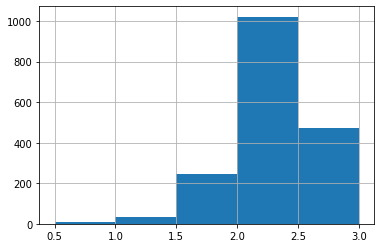

In [43]:
# 1-8
# 9:all sets combined
texts, scores = select_set(dataframe,1)
get_hist_avg(scores,5)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

# (0-1.5) bad (1.5-2.3) average (2.3-3) good

Testing for Linear Regression 

Mean squared error: 0.04663939411117041
Mean squared error in percentage: 1.554646470372347
Variance score: 0.6845865770518124
Testing for Adaboost Regression 

Mean squared error: 0.04309737478812078
Mean squared error in percentage: 1.436579159604026
Variance score: 0.7085405854630007


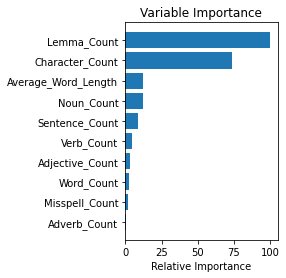

In [45]:
print('Testing for Linear Regression \n')
lin_regression(X_train,y_train,X_test,y_test)
print('Testing for Adaboost Regression \n')
adaBoost_reg(X_train,y_train,X_test,y_test)
# determines the regression line equation. the bar graph here shows the result from the adaboost line of code

In [47]:
#Dataset selection 2
# 1-8
# 9:all sets combined
texts, scores = select_set_classification(dataframe,1)
X_train, X_test, y_train, y_test,data = data_prepare(texts,scores)



      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
764              4.048295              25         352             1471   
1652             4.421053              12         304             1365   
896              4.080863              28         371             1569   
1023             4.126728              37         434             1894   
1537             4.472689              26         476             2199   
...                   ...             ...         ...              ...   
177              4.766667              20         270             1342   
36               4.276986              31         491             2167   
345              4.090062              15         322             1351   
207              4.960000              10         150              762   
1618             4.158837              24         447             1923   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
764          101               22  

In [48]:
# 1-8
# 9:all sets combined
texts, scores = select_set_classification(dataframe,1)
X_train, X_test, y_train, y_test, data = data_prepare(texts,scores)

      Average_Word_Length  Sentence_Count  Word_Count  Character_Count  \
933              4.035556               9         225              926   
335              4.922807              24         285             1457   
460              4.371882              29         441             1984   
903              4.529412              30         493             2284   
1588             4.187643              26         437             1882   
...                   ...             ...         ...              ...   
1430             4.458333              26         432             1988   
1004             4.572944              27         377             1788   
1465             4.570743              23         417             1958   
364              4.408046              17         348             1579   
450              4.601918              34         417             1982   

      Noun_Count  Adjective_Count  Verb_Count  Adverb_Count  Lemma_Count  \
933           48               20  

In [49]:
#Classification analysis
a=[0.1,1,10,100,500,1000]
for b in a:
    clf = svm.SVC(C=b, gamma=0.00001)
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    print (b)
    print (clf.score(X_test,y_test))
    print (np.mean(cross_val_score(clf, X_train, y_train, cv=3)))
    
    #results of the classification analysis

0.1
0.7869158878504673
0.780448717948718
1
0.7925233644859813
0.7852564102564102
10
0.805607476635514
0.7860576923076922
100
0.8018691588785046
0.7900641025641025
500
0.7925233644859813
0.7852564102564102
1000
0.7925233644859813
0.7748397435897436


In [50]:
# Classification Analysis Cohen's Kappa Score
clf = svm.SVC(C=100, gamma=0.00001)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print('Cohen’s kappa score: {}'.format(cohen_kappa_score(y_test,y_pred)))


Cohen’s kappa score: 0.6459298477829252


In [51]:
## Training a Linear Regression model using only 10 numerical/POS/orthographic features

linear_regressor = LinearRegression()

linear_regressor.fit(X_train, y_train)

y_pred = linear_regressor.predict(X_test)

# The coefficients
print('Coefficients: \n', linear_regressor.coef_)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % linear_regressor.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


Coefficients: 
 [ 2.04646331e-01  7.26960726e-03  9.30819804e-04  1.88678857e-04
 -1.25255339e-04  9.07675720e-04 -2.12964240e-03 -1.34615567e-03
  6.01835998e-03 -3.60417258e-03]
Mean squared error: 0.16
Variance score: 0.61
Cohen's kappa score: 0.60


In [52]:
# Training a Ridge Regression model (l2 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001])

ridge_regressor = Ridge()

grid = GridSearchCV(estimator = ridge_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))


0.5916964659741664
3.0
Mean squared error: 0.16
Variance score: 0.60
Cohen's kappa score: 0.60


In [53]:
# Training a Lasso Regression model (l1 regularization) using only 10 numerical/POS/orthographic features

alphas = np.array([3, 1, 0.3, 0.1, 0.3])

lasso_regressor = Lasso()

grid = GridSearchCV(estimator = lasso_regressor, param_grid = dict(alpha=alphas))
grid.fit(X_train, y_train)

y_pred = grid.predict(X_test)

# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % grid.score(X_test, y_test))

# Cohen’s kappa score: 1 is complete agreement
print('Cohen\'s kappa score: %.2f' % cohen_kappa_score(np.rint(y_pred), y_test))

0.5907037790560961
0.1
Mean squared error: 0.16
Variance score: 0.60
Cohen's kappa score: 0.58


C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='domain1_score', ylabel='count'>

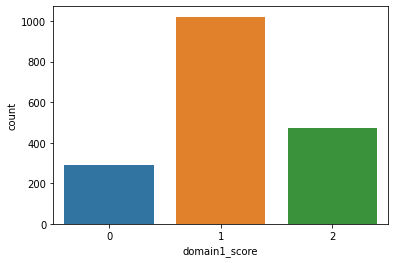

In [54]:
#Data Analysis
sns.countplot(scores)
# the essay score that has around 0 as a label for bas has a count of 250, essay score label of 1 (average) has a count of 1000, and the essay score label of 2 (good) has a count 
# of 400

C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

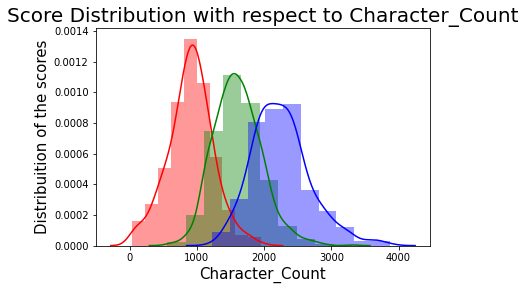

In [55]:
zero = data[(data["Character_Count"] > 0) & (scores == 0)]
one = data[(data["Character_Count"] > 0) & (scores == 1)]
two = data[(data["Character_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Character_Count"], bins=10, color='r')
sns.distplot(one["Character_Count"], bins=10, color='g')
sns.distplot(two["Character_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to Character_Count",fontsize=20)
plt.xlabel("Character_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

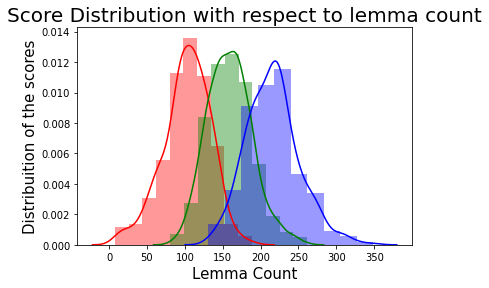

In [56]:
zero = data[(data["Lemma_Count"] > 0) & (scores == 0)]
one = data[(data["Lemma_Count"] > 0) & (scores == 1)]
two = data[(data["Lemma_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Lemma_Count"], bins=10, color='r')
sns.distplot(one["Lemma_Count"], bins=10, color='g')
sns.distplot(two["Lemma_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to lemma count",fontsize=20)
plt.xlabel("Lemma Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

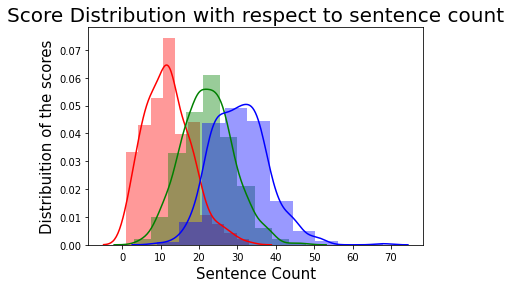

In [57]:
zero = data[(data["Sentence_Count"] > 0) & (scores == 0)]
one = data[(data["Sentence_Count"] > 0) & (scores == 1)]
two = data[(data["Sentence_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Sentence_Count"], bins=10, color='r')
sns.distplot(one["Sentence_Count"], bins=10, color='g')
sns.distplot(two["Sentence_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to sentence count",fontsize=20)
plt.xlabel("Sentence Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

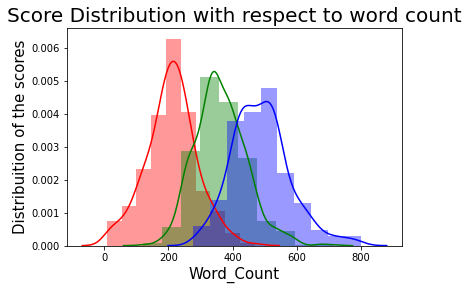

In [58]:
zero = data[(data["Word_Count"] > 0) & (scores == 0)]
one = data[(data["Word_Count"] > 0) & (scores == 1)]
two = data[(data["Word_Count"] > 0) & (scores == 2)]
sns.distplot(zero["Word_Count"], bins=10, color='r')
sns.distplot(one["Word_Count"], bins=10, color='g')
sns.distplot(two["Word_Count"], bins=10, color='b')
plt.title("Score Distribution with respect to word count",fontsize=20)
plt.xlabel("Word_Count",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()

C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Patty\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either 

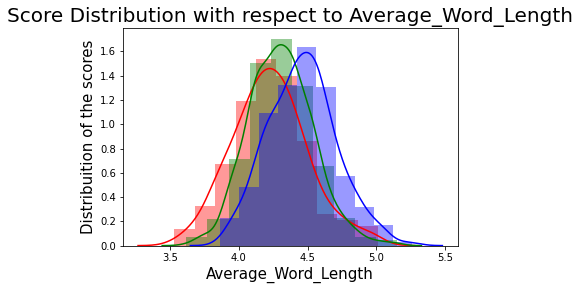

In [59]:
zero = data[(data["Average_Word_Length"] > 0) & (scores == 0)]
one = data[(data["Average_Word_Length"] > 0) & (scores == 1)]
two = data[(data["Average_Word_Length"] > 0) & (scores == 2)]
sns.distplot(zero["Average_Word_Length"], bins=10, color='r')
sns.distplot(one["Average_Word_Length"], bins=10, color='g')
sns.distplot(two["Average_Word_Length"], bins=10, color='b')
plt.title("Score Distribution with respect to Average_Word_Length",fontsize=20)
plt.xlabel("Average_Word_Length",fontsize=15)
plt.ylabel("Distribuition of the scores",fontsize=15)
plt.show()


In [60]:
print("********* Auto Grading By Using KNearestNeighborClassifier ***********")

********* Auto Grading By Using KNearestNeighborClassifier ***********


In [61]:
neighbors = 6
components = 80

In [62]:
def StemmingWordList(arrayList):
    ps = nltk.PorterStemmer()
    newList = [ps.stem(word) for word in arrayList]
    return ''.join(newList)

svd = TruncatedSVD(n_iter=10, n_components=components)
tfidf = TfidfVectorizer(min_df = 0.01, max_df=0.85, stop_words='english')

In [66]:
#import data using essay_set_descriptions and valid_set_set1
train = pd.read_csv('essay_set_descriptions.csv')
test = pd.read_csv('valid_set_set1.csv')

train.set_index('essay_id')
test.set_index('essay_id')
y_train = train['domain1_score']
y_test = test['Score']
X = pd.concat([train,test])


In [67]:
#'essay_id', 'essay_set', 'essay', 'rater1_domain1', 'rater2_domain1',       'domain1_score

In [68]:
#Creating 2 addtional features
#"Number of words" and "Number of sentences" improve the accuracy

train_numberOfSentences = X['essay'].apply(lambda x: len(x.split('.')))
train_numberOfWords = X['essay'].apply(lambda x: len(x.split()))

In [69]:
content = X['essay']
content = content.apply(lambda x: re.sub('^[a-zA-Z]', ' ', x))
content = content.apply(lambda x: StemmingWordList(x))

In [70]:
x_transform = tfidf.fit_transform(content)

In [71]:
x_transform = sparse.hstack((x_transform, train_numberOfSentences[:,None]))
x_transform = sparse.hstack((x_transform, train_numberOfWords[:,None]))

C:\Users\Patty\AppData\Local\Temp\ipykernel_19080\1077382334.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_transform = sparse.hstack((x_transform, train_numberOfSentences[:,None]))
C:\Users\Patty\AppData\Local\Temp\ipykernel_19080\1077382334.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x_transform = sparse.hstack((x_transform, train_numberOfWords[:,None]))


In [72]:
x_transform = svd.fit_transform(x_transform)

In [73]:
x_train = x_transform[:len(train)]
x_test = x_transform[len(train):]

In [74]:
nearestNeighbors = NearestNeighbors(n_neighbors=neighbors)
nearestNeighbors.fit(x_train)

NearestNeighbors(n_neighbors=6)

In [75]:
NearestNeighbors(n_neighbors=6)

NearestNeighbors(n_neighbors=6)

In [76]:
test_dist, test_ind = nearestNeighbors.kneighbors(x_test)

In [77]:
#Using custom median to predict score
i_prediction = list()
for i_dist in range(0, len(test_dist)):
    t = 0
    idx = 0
    avg = sum(test_dist[i_dist])/2
    for dist in test_dist[i_dist]:
        t += dist
        if (t < avg):
            idx += 1
        else:
            i_prediction.append(test_ind[i_dist][idx])
            break

In [78]:

prediction_list = list()
for i in i_prediction:
    prediction_list.append(y_train[i])
    

In [79]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
values = imp.fit([[1, 2], [np.nan, 3], [7, 6]])

In [80]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic')

0.07311398439213934

In [81]:
#Using true median for prediction

prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[round(neighbors/2)]])
    

In [82]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.07300615495106832

In [83]:
#Using closest item

prediction_list = list()
for val in test_ind:
    prediction_list.append(y_train[val[0]])

In [84]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.08560520353373025

In [85]:
#Using mean of score

prediction_list = list()
for val in test_ind:
    total = 0
    for i in val:
        total += y_train[i]
    avg = round(total / len(val)) 
    prediction_list.append(avg)

In [86]:
cohen_kappa_score(y_test, prediction_list,weights='quadratic') 

0.2036421885128663

# Observations
Based on the line of codes, CLASSIFICATION ANALYSIS HAS THE HIGHEST COHEN'S KAPPA SCORE (0.64). Compared to linear regression and ridge regression that has 0.60, lasso 
regression has 0.58, and KNN (median = 0.073, closest item = 0.085, mean of score = 0.20)